# News Scraper & Sentiment Analysis Dashboard - The Hindu

This notebook scrapes news articles from *The Hindu*, extracts metadata (Date, Category, Author), performs Sentiment Analysis (Positive/Negative/Neutral), and displays advanced visualizations.

In [ ]:
!pip install selenium beautifulsoup4 pandas matplotlib seaborn textblob

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import re
from textblob import TextBlob
from datetime import datetime

# Setup
%matplotlib inline
sns.set_theme(style="whitegrid")

In [2]:
def get_driver():
    options = webdriver.ChromeOptions()
    # options.add_argument('--headless')
    driver = webdriver.Chrome(options=options)
    return driver

def get_soup(driver, url):
    try:
        driver.get(url)
        time.sleep(3)
        return BeautifulSoup(driver.page_source, 'html.parser')
    except Exception as e:
        print(f"Error fetching {url}: {e}")
        return None

In [3]:
# Scrape Homepage for Links
url = "https://www.thehindu.com/"
driver = get_driver()
print("Fetching homepage...")
soup = get_soup(driver, url)

links = []
seen_urls = set()

if soup:
    # Gather more links to get a good dataset for charts
    for tag in soup.select('h3.title a, h2.title a, div.story-card a'):
        href = tag.get('href')
        if href and href not in seen_urls and 'thehindu.com' in href and '/article' in href:
            links.append(href)
            seen_urls.add(href)

# Fetch top 15 articles for better charting
links = links[:15]
print(f"Found {len(links)} articles to process.")

Fetching homepage...
Found 15 articles to process.


In [4]:
# Scrape Individual Articles with Enhanced Metadata
articles_data = []

for link in links:
    print(f"Scraping: {link}")
    try:
        art_soup = get_soup(driver, link)
        if not art_soup: continue
        
        # Headline
        title_tag = art_soup.select_one('h1.title')
        title = title_tag.get_text(strip=True) if title_tag else "N/A"
        
        # Extract Category from URL (simple heuristic)
        # e.g., .../news/national/article...
        parts = link.split('/')
        category = "General"
        if 'news' in parts:
             try:
                 idx = parts.index('news')
                 if idx + 1 < len(parts):
                     category = parts[idx+1].capitalize()
             except:
                 pass
        elif 'sport' in parts:
            category = 'Sport'
        elif 'business' in parts:
            category = 'Business'
        elif 'entertainment' in parts:
            category = 'Entertainment'
            
        # Date Extraction
        # Try meta tag first
        pub_date = None
        meta_date = art_soup.find('meta', property='article:published_time')
        if meta_date:
            # Format often: 2024-05-12T07:30:00+05:30
            dt_str = meta_date.get('content')
            try:
                pub_date = datetime.fromisoformat(dt_str).date()
            except:
                pass
        
        if not pub_date:
            pub_date = datetime.now().date() # Fallback for demo

        # Content
        body_div = art_soup.select_one('div[id^="content-body-"]')
        content = body_div.get_text(strip=True) if body_div else ""
        if not content:
             paras = art_soup.select('div.article-body p')
             content = " ".join([p.get_text(strip=True) for p in paras])
        
        articles_data.append({
            'url': link,
            'headline': title,
            'category': category,
            'date': pub_date,
            'content': content
        })
        
    except Exception as e:
        print(f"Error scraping {link}: {e}")

driver.quit()

Scraping: https://www.thehindu.com/opinion/lead/the-right-to-disconnect-in-an-always-on-economy/article70479023.ece
Scraping: https://www.thehindu.com/sci-tech/science/nitrogen-vacancy-centres-diamond-quantum-spins-superradiant-maser/article70472909.ece
Scraping: https://www.thehindu.com/opinion/columns/cricket-is-collateral-damage-in-a-game-of-political-expediency/article70477819.ece
Scraping: https://www.thehindu.com/sci-tech/health/health-matters-newsletter-where-health-stands-as-the-year-begins/article70476834.ece
Scraping: https://www.thehindu.com/news/national/tamil-nadu/tn-chief-minister-vs-governor-when-eggs-stones-were-hurled-at-channa-reddy-convoy-and-jayalalithaa-sought-his-recall-in-1995/article70478566.ece
Scraping: https://www.thehindu.com/news/national/delhi-court-orders-removal-of-posts-linking-bjp-leader-to-ankita-bhandari-murder-case/article70481143.ece
Scraping: https://www.thehindu.com/news/international/trump-venezuela-30-to-50-million-barrels-of-oil-plan-turn-over

In [5]:
# Sentiment Analysis Functions with Chunking
def chunk_text(text, chunk_size=500, overlap=50):
    """
    Splits text into chunks of `chunk_size` characters with `overlap`.
    """
    if not text:
        return []
    chunks = []
    start = 0
    text_len = len(text)
    
    while start < text_len:
        end = min(start + chunk_size, text_len)
        chunks.append(text[start:end])
        if end == text_len:
            break
        start += (chunk_size - overlap)
    return chunks

def analyze_sentiment_with_chunks(text):
    """
    Analyzes sentiment by averaging the polarity of text chunks.
    """
    if not text:
        return 0.0, 'Neutral'
    
    chunks = chunk_text(text)
    if not chunks:
        return 0.0, 'Neutral'
        
    chunk_polarities = []
    for chunk in chunks:
        blob = TextBlob(chunk)
        chunk_polarities.append(blob.sentiment.polarity)
    
    # Average polarity
    avg_polarity = sum(chunk_polarities) / len(chunk_polarities)
    
    if avg_polarity > 0.05:
        return avg_polarity, 'Positive'
    elif avg_polarity < -0.05:
        return avg_polarity, 'Negative'
    else:
        return avg_polarity, 'Neutral'

# Apply Sentiment Analysis
df = pd.DataFrame(articles_data)
if not df.empty:
    df[['sentiment_score', 'sentiment_label']] = df['content'].apply(
        lambda x: pd.Series(analyze_sentiment_with_chunks(x))
    )

    print("Processed Data (with Chunking):")
    print(df[['headline', 'category', 'date', 'sentiment_label', 'sentiment_score']].head())
else:
    print("No articles to process.")

Processed Data (with Chunking):
                                            headline  category        date  \
0  The right to disconnect in an ‘always-on’ econ...   General  2026-01-06   
1  The perfect flaw: how a diamond defect is chan...   General  2026-01-07   
2  BCCI vs BCB: Cricket is collateral damage in a...   General  2026-01-06   
3      Where health stands as the year beginsPremium   General  2026-01-06   
4  When eggs, stones were hurled at T.N. Governor...  National  2026-01-07   

  sentiment_label  sentiment_score  
0        Positive         0.096066  
1        Positive         0.115856  
2         Neutral         0.008144  
3        Positive         0.132451  
4         Neutral         0.011636  


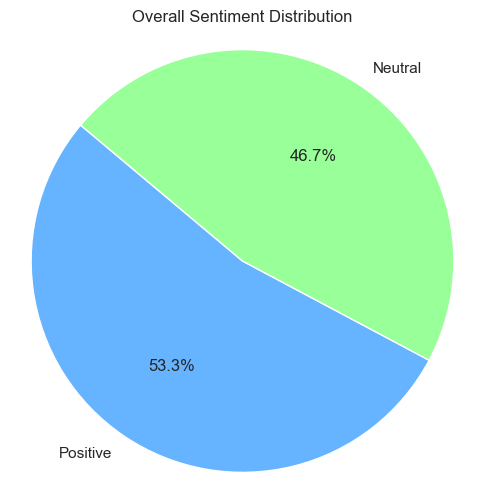

In [6]:
# 1. Pie Chart: Overall Sentiment Distribution
plt.figure(figsize=(6, 6))
sentiment_counts = df['sentiment_label'].value_counts()
colors = {'Positive': '#66b3ff', 'Neutral': '#99ff99', 'Negative': '#ff9999'}
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=[colors.get(x, '#ccc') for x in sentiment_counts.index])
plt.title('Overall Sentiment Distribution')
plt.axis('equal')
plt.show()

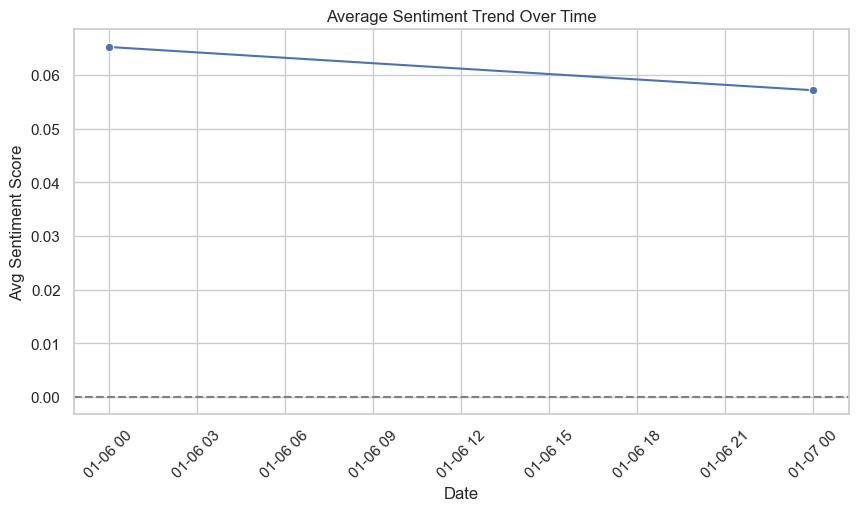

In [7]:
# 2. Line Chart: Average Sentiment Over Time
# Group by Date
time_trend = df.groupby('date')['sentiment_score'].mean().reset_index()
if not time_trend.empty:
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=time_trend, x='date', y='sentiment_score', marker='o')
    plt.title('Average Sentiment Trend Over Time')
    plt.xlabel('Date')
    plt.ylabel('Avg Sentiment Score')
    plt.axhline(0, color='gray', linestyle='--')
    plt.xticks(rotation=45)
    plt.show()

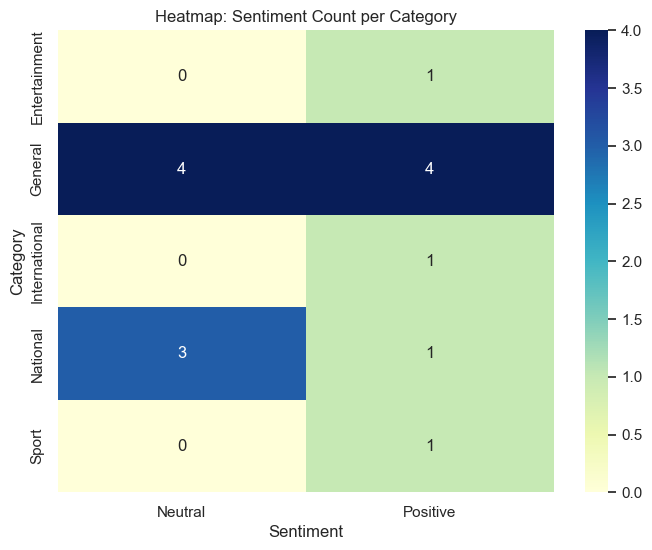

In [8]:
# 3. Heatmap: Category vs Sentiment
# Since we might not have many days, we compare Categories vs Sentiment Label Counts
# Pivot Table: Rows=Category, Cols=Sentiment Label, Values=Count
pivot_table = pd.crosstab(df['category'], df['sentiment_label'])

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt='d')
plt.title('Heatmap: Sentiment Count per Category')
plt.ylabel('Category')
plt.xlabel('Sentiment')
plt.show()